# Sky Brightness Model Generation #
### Nitika Yadlapalli ###
This notebook contains functions to calculate the contribution to brightness temperature from a disk, halo, and extragalactic sources. Test maps and plots are generated to verify the models. Functions written for the galactic contribution will be copied over and used to run MCMC models for finding the best model parameters to fit the data. Extragalactic contribution will be a fixed value at all coordinates and will be calculate in this notebook and then copied over as well

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from scipy.integrate import quad
from scipy import stats
from const import *

import ModelDefinitions as MD
import LogProb as LP
import importlib
importlib.reload(LP);
importlib.reload(MD);

In [2]:
# function describing sky brightness, based on sky coordinates, 
# geometry of disk/halo, and power densities of each
# l and b given in degrees (as from hp.pix2ang) - convert to radians
# d = distance of sun from center of galaxy

def LineOfSightDisk(l, b, d, R_disk, h_disk):
    
    # first calculate length of line of sight through disk
    
    # first calculate length of line of sight through disk
    
    l = np.array(l)
    b = np.array(b)
    
    l = np.deg2rad(l)
    b = np.deg2rad(b)

    l = np.amin([l, (2*np.pi)-l],axis=0)
    b = np.abs(b)
    B_disk =  -l - np.arcsin((d/R_disk)*np.sin(l)) + np.pi
    r_disk = np.sqrt(-(2*R_disk*d*np.cos(B_disk)) + (R_disk**2) + (d**2))
    
    b_crit = np.arctan(0.5*h_disk/r_disk)
    b_below = np.nan_to_num((b <= b_crit)*r_disk/(np.cos(b)))
    b_above = np.nan_to_num((b > b_crit)*0.5*h_disk/(np.sin(b)))
    
    D_disk = b_below+b_above
        
    return np.array(D_disk)
        

def LineOfSightHalo(l, b, d, R_halo):  
    
    # next calculate length of line of sight through halo
    
    l = np.deg2rad(np.array(l))
    b = np.deg2rad(np.array(b))
    
    l = np.minimum(l, (2*np.pi)-l)
    
    b = np.abs(b)
    b_ = np.pi - b
    
    d_proj = d*np.abs(np.cos(l))
    B_halo1 = np.pi - l - np.arcsin((d/R_halo)*np.sin(l))
    
    R_eff_above = np.sqrt((R_halo**2) + (d**2) - (2*R_halo*d*np.cos(B_halo1))) + d_proj
    B_halo_above = (np.pi - b_ - np.arcsin((d_proj/R_eff_above)*np.sin(b)))
    D_tot_above = (l >= np.pi/2)*(np.sqrt((R_eff_above**2) + (d_proj**2) - (2*R_eff_above*d_proj*np.cos(B_halo_above))))
        
    R_eff_below = np.sqrt((R_halo**2) + (d**2) - (2*R_halo*d*np.cos(B_halo1))) - d_proj
    B_halo_below = (np.pi - b - np.arcsin((d_proj/R_eff_below)*np.sin(b)))
    D_tot_below = (l < np.pi/2)*(np.sqrt((R_eff_below**2) + (d_proj**2) - (2*R_eff_below*d_proj*np.cos(B_halo_below))))

    # fixes bug for low R_halo (<~2.3 d)
    D_tot_above[np.isnan(D_tot_above)] = 0.
    D_tot_below[np.isnan(D_tot_below)] = 0.
    
    
    D_halo = D_tot_above + D_tot_below
    
    return D_halo

def SkyBrightness(D_disk, D_halo, j_disk, j_halo):
    
        
    # specific intensity (erg s^-1 cm^-2 Hz^-1 sr^-1) = emission coefficient * distance 
    I = j_disk*D_disk + j_halo*D_halo
    
    return I
    
        
    

In [45]:
def Spheroid(l, b, R_disk, h_disk):
    
    phi = np.deg2rad(np.array(l))
    theta = np.deg2rad(90 - np.array(b))
    
    nx = np.sin(theta)*np.cos(phi)
    ny = np.sin(theta)*np.sin(phi)
    nz = np.cos(theta)
    
    t = np.array([np.linspace(0,d+R_disk,2000)])
    
    x = -d + np.multiply(t.T, nx)
    y = np.multiply(t.T, ny)
    z = np.multiply(t.T, nz)
    
    
    res = np.abs(1 - (x**2 + y**2)/R_disk**2 - z**2/(0.5*h_disk)**2)
    idx = np.argmin(res, axis=0)
    
    D_sph = np.sqrt((-d - np.diag(x[idx]))**2 + np.diag(y[idx])**2 + np.diag(z[idx])**2)
    
    return np.ravel(D_sph)
    

In [46]:

nu=1420e6

param_init = [1.5*d, 0.3*d, 10**(-40), 3*d, 10**(-41), 2.0]
R_disk, h_disk, j_disk, R_halo, j_halo, T_bkg = param_init

print(LineOfSightDisk([0,90,180], [0,0,0], d, R_disk, h_disk)*j_disk*(c**2)/(2*k*(nu**2)))
print(Spheroid([0,90,180], [0,0,0], R_disk, h_disk)*j_disk*(c**2)/(2*k*(nu**2)))

[9.97397014 4.46049505 1.99479403]
[9.97397014 4.46059495 1.99579192]


/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


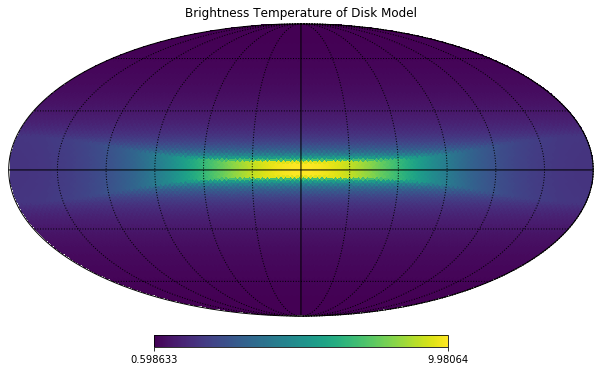

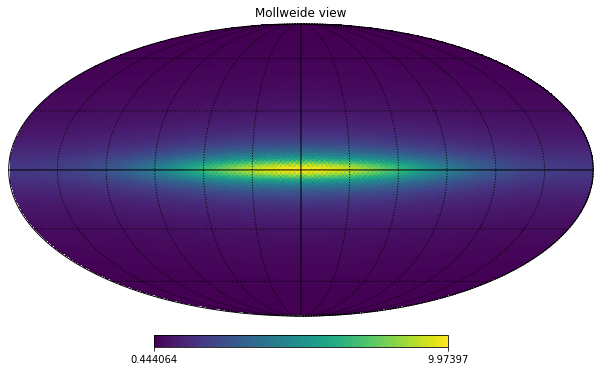

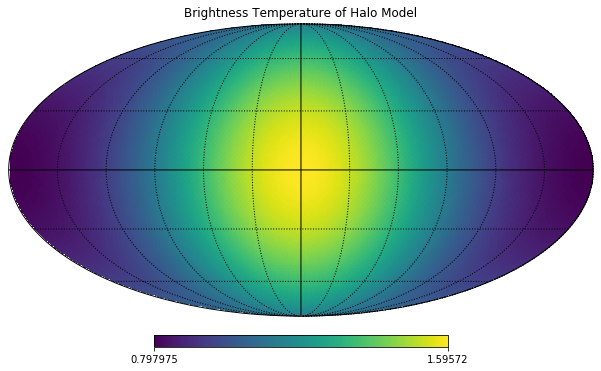

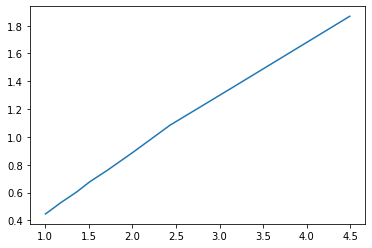

In [47]:
# 1420 MHz values taken from Subrahmanyan paper
# all distances in paper given in units of the solar circle

T_disk = LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk*(c**2)/(2*k*(nu**2))
T_halo1 = LineOfSightHalo(l, b, d, R_halo)*j_halo*(c**2)/(2*k*(nu**2))
T_sph = Spheroid(l,b,R_disk,h_disk)*j_disk*(c**2)/(2*k*(nu**2))

hp.mollview(T_disk, title="Brightness Temperature of Disk Model");
hp.graticule();

hp.mollview(T_sph)
hp.graticule()

hp.mollview(T_halo1, title = "Brightness Temperature of Halo Model");
hp.graticule();

plt.figure()
cscb, Tb_mean = MD.cscbplot(T_sph, NSIDE_dg)
plt.plot(cscb, Tb_mean)

/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1176: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/nitikayad96/.local/lib/python3.6/site-packages/healpy/projaxes.py:1177: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


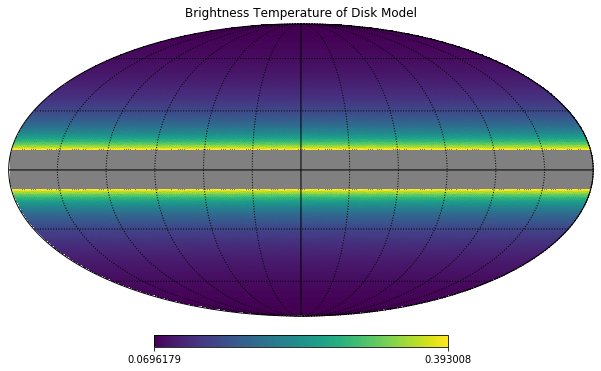

In [6]:
# Mask all pixels between -10 < b < +10 by setting them all to zero

idx = hp.query_strip(NSIDE, np.deg2rad(90-10), np.deg2rad(90+10))
I_disk[idx] = None
T_disk[idx] = None

hp.mollview(T_disk, title="Brightness Temperature of Disk Model")
hp.graticule()
plt.savefig('notes/disk_mod.jpg')

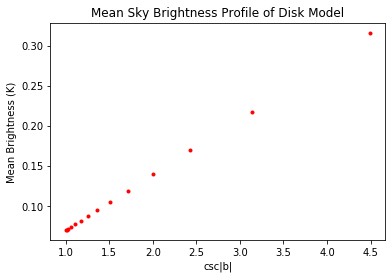

In [8]:
# Construct a T_b vs csc(b) graph

b_range = np.linspace(10,90,15)

cscb = []
Tb = []

for i in range(len(b_range)-1):
    
    b1 = 90 - b_range[i]
    b2 = 90 - b_range[i+1]
    
    bmid = 0.5*(b_range[i] + b_range[1+i])
    
    cscb.append(1/(np.sin(np.deg2rad(bmid)))) 
    
    idx = hp.query_strip(NSIDE, np.deg2rad(b2), np.deg2rad(b1))
    I_v = np.mean(I_disk[idx])
    
    T = I_v*c**2/(2*k*nu**2)
    Tb.append(T)

plt.figure(0)
plt.plot(cscb,Tb,'r.')
plt.xlabel('csc|b|')
plt.ylabel('Mean Brightness (K)')
plt.title('Mean Sky Brightness Profile of Disk Model')
plt.savefig('notes/cscb.jpg')

    
    

In [9]:
# Extragalactic source contribution 

a = -0.7 # spectral index

nu = 1420e6

In [10]:
## contribution from 0.05 to 1000 mJy - see Hopkins et al 2002 ##

nu1 = 1420e6

S_low1 = (0.05*1e-3)*(nu/(nu1))**a
S_up1 = (1000*1e-3)*(nu/(nu1))**a


def Hopkins2002(S):
    
    # S in Jy
    x = np.log10(S*1000)
    
    F = -0.008*x**6 + 0.057*x**5 - 0.121*x**4 - 0.049*x**3 + 0.376*x**2 + 0.508*x + 0.859
    G = (10**F)*(S**-1.5)
    
    return G

S1 = quad(Hopkins2002, S_low1, S_up1)

#S1 = S1_1420[0]*(nu/(nu1))**a # convert everything to freq in question

print(S1[0]) # Jy/sr  


4512.449118641871


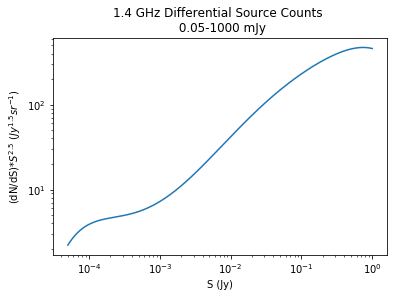

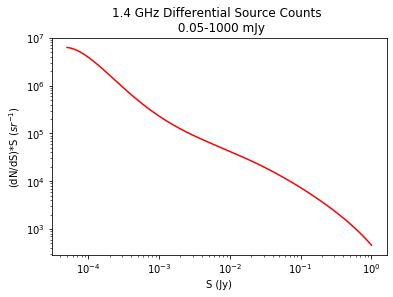

In [11]:
# verify behavior of function in Hopkins 2012

N = np.logspace(np.log10(0.05/1000), np.log10(1000/1000), 500)
Y = []
YY = []

for S in N:
    
    x = np.log10(S*1000)
    
    F = -0.008*x**6 + 0.057*x**5 - 0.121*x**4 - 0.049*x**3 + 0.376*x**2 + 0.508*x + 0.859
    G = (10**F)*(S**-1.5)
    
    Y.append(10**F)
    YY.append(G)
    
plt.figure(5)
plt.plot(N,Y)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S (Jy)')
plt.ylabel('(dN/dS)*$S^{2.5}$ ($Jy^{1.5}sr^{-1}$)')
plt.title('1.4 GHz Differential Source Counts \n 0.05-1000 mJy')
plt.savefig('notes/Hopkins1.jpg')

plt.figure(6)
plt.plot(N,YY, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('(dN/dS)*S ($sr^{-1}$)')
plt.xlabel('S (Jy)')
plt.title('1.4 GHz Differential Source Counts \n 0.05-1000 mJy')
plt.savefig('notes/Hopkins2.jpg')

3609.3997100859333


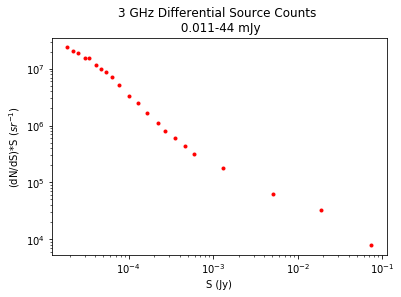

In [12]:
## contribution from 0.011 to 44 mJy - see Smolcic et al 2017 ##

## can use this to also verify that the integrated brightness 
#  calculated in the Hopkins 2012 paper is consistent?? ##

nu2 = 3e9
S_range2 = [0.011, 0.013, 0.015, 0.018, 0.020, 0.024, 0.028,
            0.032, 0.037, 0.045, 0.059, 0.076, 0.098, 0.13, 0.16,
            0.21, 0.27, 0.35, 0.78, 3.0, 11, 44] # in mJy

counts2 = [0.866, 0.952, 1.10, 1.16, 1.40, 1.38, 1.47, 1.57, 1.59,
           1.58, 1.53, 1.67, 1.60, 1.65, 1.62, 1.82, 1.93, 2.03, 3.95,
           10.4, 37.4, 72.3] # in Jy^1.5 sr^-1

S_range2 = [s/1000 for s in S_range2]

for i in range(len(S_range2)):
    
    counts2[i] = counts2[i]/(S_range2[i]**1.5)
    
S_range2 = [s*(nu/(nu2))**a for s in S_range2]
    
S2 = np.trapz(counts2, S_range2) # Jy/sr

#S2 = S2_*(nu/(nu2))**a #convert to frequency of interest (nu)
print(S2)

plt.plot(S_range2, counts2, 'r.')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('(dN/dS)*S ($sr^{-1}$)')
plt.xlabel('S (Jy)')
plt.title('3 GHz Differential Source Counts \n 0.011-44 mJy')
plt.savefig('notes/Smolcic.jpg')

In [13]:
## compare range that overlaps between Hopkins and Smolcic papers

t1 = quad(Hopkins2002, .059/1000, 44/1000)
t2 = np.trapz(counts2[10::], S_range2[10::])*(nu/(nu2))**a

print(t1[0])
print(t2)

# from this, seems like Smolcic data points predit larger brightness 
# than the Hopkins function? 

2344.570408839439
4812.2061643287625


(554.4721285267351, 7.888600585658628e-07)


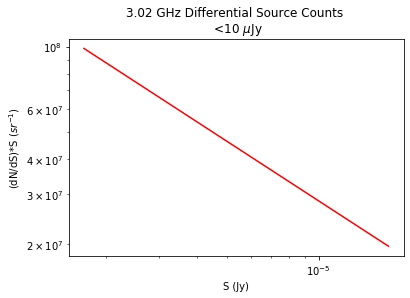

In [14]:
## contribution from 1 < S < 10 microJy sources - see Condon et al 2012 ##
nu3 = 3.02e9
S_low3 = (1/1e6)*(nu/(nu3))**a
S_up3 = (10/1e6)*(nu/(nu3))**a

def Condon2012(S):
    # S in Jy
    n = 9000*(S**-1.7)
    return n*S

t3 = quad(Condon2012, S_low3, S_up3)
#t3 = t3_[0]*(nu/(nu3))**a # convert to freq of interest (nu)
print(t3)

X3 = np.linspace(S_low3,S_up3, 500)
Y3 = [Condon2012(x) for x in X3]

plt.plot(X3, Y3, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('(dN/dS)*S ($sr^{-1}$)')
plt.xlabel('S (Jy)')
plt.title('3.02 GHz Differential Source Counts \n <10 $\mu$Jy')
plt.savefig('notes/Condon.jpg', bbox_inches = "tight")

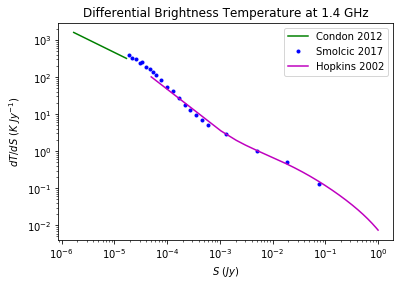

In [15]:
## Put all of the source counts together ##

plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$S\ (Jy)$')
plt.ylabel('$dT/dS\ (K\ Jy^{-1})$')

S1 = np.linspace(S_low1, S_up1, 1000)
dTdS1 = [Hopkins2002(s)*Jy*(c**2)/(2*k*(nu**2)) for s in S1]

S2 = S_range2
dTdS2 = [x*Jy*(c**2)/(2*k*(nu**2)) for x in counts2]

S3 = np.linspace(S_low3, S_up3, 1000)
dTdS3 = [Condon2012(s)*Jy*(c**2)/(2*k*(nu**2)) for s in S3]

plt.plot(S3, dTdS3, 'g-', label="Condon 2012")
plt.plot(S2, dTdS2, 'b.', label="Smolcic 2017")
plt.plot(S1, dTdS1, 'm-', label="Hopkins 2002")

plt.legend()

plt.title("Differential Brightness Temperature at 1.4 GHz")
plt.savefig('notes/T_b.jpg')

In [16]:
idx = 0
for s in S2:
    if s < S_low1:
        idx+=1
        
T1 = quad(Hopkins2002, S2[idx], S_up1)[0]*Jy*(c**2)/(2*k*(nu**2))
T2 = np.trapz(dTdS2[0:idx], S2[0:idx])
T3 = quad(Condon2012, S_low3, S_up3)[0]*Jy*(c**2)/(2*k*(nu**2))

T = T1 + T2 + T3
# print(T1)
# print(T2)
# print(T3)
print(T) # in Kelvin

## How do we want to report errors on this value? ##

0.0886647260992252
